# Image Segmentation

## 1. Load Pre-trained VGG-16 Model into TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import os.path
import helper
import warnings
#import project_tests as tests

C:\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_vgg(sess, vgg_path):
    model= tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)
    
    graph =tf.get_default_graph()
    image_input=graph.get_tensor_by_name('image_input:0')
    keep_prob=graph.get_tensor_by_name('keep_prob:0')
    layer3=graph.get_tensor_by_name('layer3_out:0')
    layer4=graph.get_tensor_by_name('layer4_out:0')
    layer7=graph.get_tensor_by_name('layer7_out:0')
    return image_input, keep_prob, layer3, layer4, layer7


## 2. Create Layers for FCN

In [19]:
def new_layers(layer3_out, layer4_out, layer7_out, num_classes):
    layer3, layer4, layer7=layer3_out, layer4_out, layer7_out
    fcn8new=tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name='fcn8new')
    fcn9new=tf.layers.conv2d_transpose(fcn8new, filters=layer4.get_shape().as_list()[-1], kernel_size=4, 
                                   strides=(2,2), padding='SAME', name='fcn9new')
    fcn9_skip_connected=tf.add(fcn9new, layer4, name='fcn9_plus_layer4')
    fcn10=tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1], kernel_size=4,
                                    strides=(2,2), padding='SAME', name='fcn10')
    fcn10_skip_connected=tf.add(fcn10, layer3, name='fcn10_plus_layer3')
    fcn11=tf.layers.conv2d_transpose(fcn10_skip_connected, filters=num_classes, kernel_size=16, 
                                    strides=(8,8), padding='SAME', name='fcn11')
    return fcn11
    

## 3. Optimize FCN

In [33]:
def optimize(last_layer,correct_label, learning_rate, num_classes):
    logits=tf.reshape(last_layer, (-1, num_classes), name='fcn_logits')
    correct_label_reshaped=tf.reshape(correct_label, (-1, num_classes))
    
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
    loss_op = tf.reduce_mean(cross_entropy, name='fcn_loss')
    train_op= tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name='fcn_train_op')
    return logits, train_op, loss_op

## 4. Define Train Function

In [32]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image, correct_label, 
            keep_prob, learning_rate):
    keep_prob_value=0.5
    learning_rate_value=0.001
    for epoch in range(epochs):
        total_loss=0
        for X_batch, gt_batch in get_batches_fn(batch_size):
            loss, _=sess.run([cross_entropy_loss, train_op],
                            feed_dict={
                                input_image:X_batch, correct_label:gt_batch, 
                                keep_prob:keep_prob_value, learning_rate: learning_rate_value
                            })
            total_loss+=loss
        print('EPOCH {}:'.format(epoch+1))
        print('Loss = {:.3f}'.format(total_loss))

## 5. Train the model

In [42]:
num_classes=2
image_shape=(160,576)
data_dir= './data'
runs_dir='./runs'
vgg_path='./data/vgg'
get_batches_fn=helper.gen_batch_function(os.path.join(data_dir,'data_road/training') , image_shape)
helper.maybe_download_pretrained_vgg(data_dir)

In [43]:
correct_label=tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], num_classes])

In [44]:
epochs=30
batch_size=16
learning_rate=tf.placeholder(tf.float32)
keep_prob=tf.placeholder(tf.float32)

In [ ]:
def run():
    with tf.Session() as session:
        image_input, keep_prob, layer3, layer4, layer7=load_vgg(session, vgg_path)
        model_output=new_layers(layer3, layer4, layer7, num_classes)
        logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, num_classes)
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())
        print('Model build successful, start training')

        train_nn(session, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input,correct_label, 
                 keep_prob, learning_rate)
        helper.save_inference_samples(runs_dir, data_dir, session, image_shape, logits, keep_prob, image_input)

In [ ]:

with tf.Session() as session:
    image_input, keep_prob, layer3, layer4, layer7=load_vgg(session, vgg_path)
    model_output=new_layers(layer3, layer4, layer7, num_classes)
    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, num_classes)
    session.run(tf.global_variables_initializer())
    session.run(tf.local_variables_initializer())
    print('Model build successful, start training')

    train_nn(session, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input,correct_label, 
             keep_prob, learning_rate)
    helper.save_inference_samples(runs_dir, data_dir, session, image_shape, logits, keep_prob, image_input)

In [41]:
tf.reset_default_graph()


## 6. Tests Results

### First Trial

- epoch:30
- keepprob:0.5

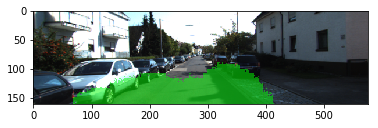

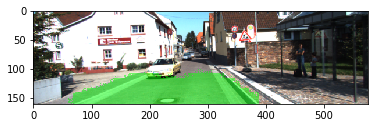

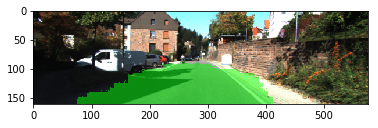

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
image0=plt.imread('runs/first trial/uu_000023.png')
image1=plt.imread('runs/first trial/uu_000049.png')
image2=plt.imread('runs/first trial/uu_000090.png')
plt.imshow(image0)
plt.show()
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

### Second Trial

- epoch:35
- keepprob:0.75

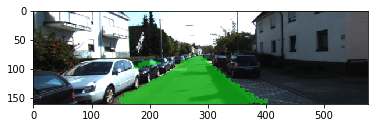

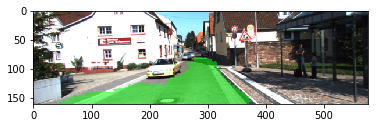

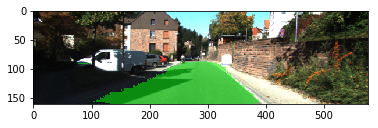

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
image0=plt.imread('runs/second trial/uu_000023.png')
image1=plt.imread('runs/second trial/uu_000049.png')
image2=plt.imread('runs/second trial/uu_000090.png')
plt.imshow(image0)
plt.show()
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()